# Vehicle routing problem with vehicle capacity: CVRP 

- Modeling of optimization formulation using PuLP

In [2]:
# !pip install pulp # if you need

     |████████████████████████████████| 14.2 MB 1.4 MB/s eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
import pulp
from scipy.spatial import distance_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
customer_count = 10 # id=0: depot
vehicle_count = 4 
vehicle_capacity = 50 

np.random.seed(seed=32)

# location coordinates and amount of package (demand) of each customer
df = pd.DataFrame({"x":np.random.randint(0,100, customer_count), 
                   "y":np.random.randint(0, 100, customer_count), 
                   "demand":np.random.randint(5, 20, customer_count)})

# if id=0, demand=0
df.iloc[0].x = 50
df.iloc[0].y = 50
df.iloc[0].demand = 0

# calculate the distance between nodes as a cost
cost = pd.DataFrame(distance_matrix(df.loc[:,["x","y"]].values, df.loc[:,["x","y"]].values), index=df.index, columns=df.index).values

df.head()

,x,y,demand
0,50,50,0
1,43,4,15
2,5,11,9
3,54,81,7
4,62,3,9


(-10.0, 110.0)

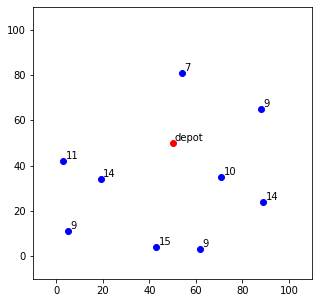

In [5]:
# Visualization of depot and customer locations
# The subscripts indicate the demand
plt.figure(figsize=(5,5))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i]+1, df.y[i]+1, "depot")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i]+1, df.y[i]+1, str(df.demand[i]))
plt.xlim([-10, 110])
plt.ylim([-10, 110])

In [6]:
# Modeling of optimization formulation using PuLP
for vehicle_count in range(1,vehicle_count+1):

    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # Decision variables
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # Optimization function
    problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) for j in range(customer_count) for i in range (customer_count))

    # Constraints
    # Each customer location is visited once per vehicle
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count) for k in range(vehicle_count)) == 1 

    # Departing from depot and returning to depot
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # The number of vehicles coming to a customer is the same as the number of vehicles leaving.
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    # Not exceed the maximum capacity 
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # Subtour Elimination Constraints
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    # Solve problem
    if problem.solve() == 1:
        print('Number of vehicles:', vehicle_count)
        print('Opimization function value:', pulp.value(problem.objective))
        break

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/envs/py39/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/sc/gyb0p4hx6njb4b201028h5xw0000gn/T/6a6eb9250573464f942b6cd7aaa00145-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/sc/gyb0p4hx6njb4b201028h5xw0000gn/T/6a6eb9250573464f942b6cd7aaa00145-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 529 COLUMNS
At line 10376 RHS
At line 10901 BOUNDS
At line 10992 ENDATA
Problem MODEL has 524 rows, 90 columns and 9576 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.04

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom

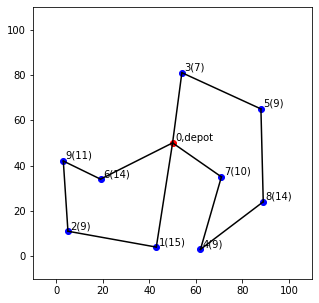

In [7]:
# Visualization of optimized routes
plt.figure(figsize=(5,5))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i]+1, df.y[i]+1, str(i)+",depot")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i]+1, df.y[i]+1, str(i)+"("+str(df.demand[i])+")")
plt.xlim([-10, 110])
plt.ylim([-10, 110])

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.x[i], df.x[j]], [df.y[i], df.y[j]], c="black")